# Neural Systems - Final Project
## Endoscopic Artefact Detection


In [ ]:
pip install openmim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mim install mmcv-full

mmcv-full==1.5.2 existed.


In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git

fatal: destination path 'mmdetection' already exists and is not an empty directory.


In [ ]:
!cd mmdetection

In [ ]:
pip install mmdet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -r '/content/mmdetection/requirements/build.txt'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -v -e .

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [ ]:
# Only needed i we are going to train de model again
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth \
      -O checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-06-08 03:44:27--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.



In [ ]:
#%cd mmdetection

import mmcv
import matplotlib.pyplot as plt
import os.path as osp
from PIL import Image
import matplotlib.patches as mpatches
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
from mmcv import Config
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
#from mmdet.core.evaluation import plot_iou_recal

import zipfile

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [ ]:
from mmdetection.tools.analysis_tools.benchmark import measure_inference_speed

In [ ]:
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/Shareddrives/NeuralSystems-Challenge/dataset.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

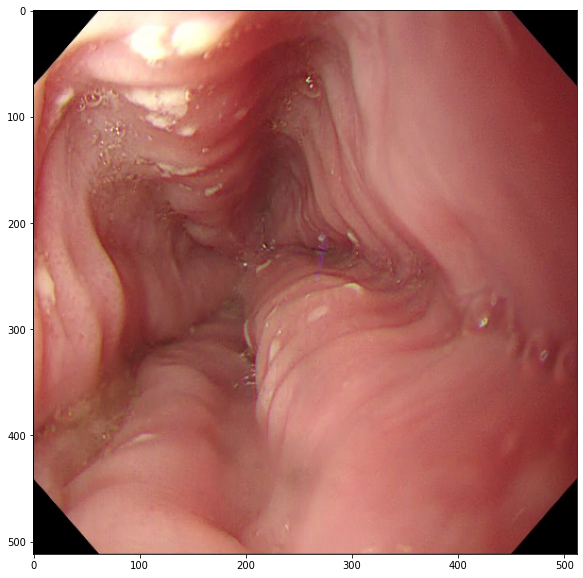

In [ ]:
img = mmcv.imread('/content/dataset/framesOnly/EAD2020_frameOnly_00001.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

## Model

In [ ]:
from mmcv import Config
cfg = Config.fromfile('/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

In [ ]:
from mmdet.apis import set_random_seed


In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class ChallengeDataset(CustomDataset):

    CLASSES = ('specularity', 'saturation', 'artifact', 'blur', 'contrast', 'bubbles', 'instrument', 'blood')

    def load_annotations(self, ann_file):
        #cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]

            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)

            # load annotations
            lines = mmcv.list_from_file(osp.join(self.img_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [int(x[0]) for x in content]
            #bboxes = [[float(info) for info in x[4:8]] for x in content]

            # transform to coco format [top-left-x, top-left-y, width, height]
            bboxes = []
            for box in content:
              w_coco = float(box[3])*width
              h_coco = float(box[4])*height
              x_coco = (float(box[1])*width) - (w_coco/2)
              y_coco = (float(box[2])*height) - (h_coco/2)
              x2_coco = (float(box[1])*width) + (w_coco/2)
              y2_coco = (float(box[2])*height) + (h_coco/2)
              bbox_temp = [x_coco, y_coco, x2_coco, y2_coco]
              bboxes.append(bbox_temp)


            data_anno = dict(
                bboxes=np.array(bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(bbox_names, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [ ]:

# Modify dataset type and path
cfg.dataset_type = 'ChallengeDataset'
cfg.data_root = '/content/dataset/'

cfg.data.test.type = 'ChallengeDataset'
cfg.data.test.data_root = '/content/dataset/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = '/content/dataset//Sequence/'

cfg.data.train.type = 'ChallengeDataset'
cfg.data.train.data_root = '/content/dataset/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = '/content/dataset//framesOnly'

cfg.data.val.type = 'ChallengeDataset'
cfg.data.val.data_root = '/content/dataset/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = '/content/dataset//Sequence/'


# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 8
# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = '/content/checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
cfg.evaluation.iou_thr = iou_thr
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]
cfg.device = 'cuda'
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/mmdet/datasets/custom.py:180: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
2022-06-06 23:27:16,111 - mmdet - INFO - Automatic scaling of learning rate (LR) has b

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.7 task/s, elapsed: 34s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-06 23:35:07,490 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7980 | 0.750  | 0.528 |
| saturation  | 239  | 1574 | 0.774  | 0.586 |
| artifact    | 1006 | 7666 | 0.849  | 0.451 |
| blur        | 78   | 1047 | 0.962  | 0.211 |
| contrast    | 276  | 1825 | 0.899  | 0.776 |
| bubbles     | 717  | 2495 | 0.446  | 0.143 |
| instrument  | 159  | 556  | 0.805  | 0.350 |
| blood       | 82   | 242  | 0.232  | 0.049 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.387 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-06 23:35:08,194 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7980 | 0.717  | 0.486 |
| saturation  | 239  | 1574 | 0.766  | 0.572 |
| artifact    | 1006 | 7666 | 0.818  | 0.415 |
| blur        | 78   | 1047 | 0.936  | 0.158 |
| contrast    | 276  | 1825 | 0.877  | 0.751 |
| bubbles     | 717  | 2495 | 0.421  | 0.128 |
| instrument  | 159  | 556  | 0.786  | 0.325 |
| blood       | 82   | 242  | 0.220  | 0.028 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.358 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-06 23:35:08,894 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7980 | 0.677  | 0.441 |
| saturation  | 239  | 1574 | 0.762  | 0.525 |
| artifact    | 1006 | 7666 | 0.778  | 0.362 |
| blur        | 78   | 1047 | 0.897  | 0.140 |
| contrast    | 276  | 1825 | 0.859  | 0.723 |
| bubbles     | 717  | 2495 | 0.402  | 0.114 |
| instrument  | 159  | 556  | 0.774  | 0.313 |
| blood       | 82   | 242  | 0.220  | 0.027 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.331 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-06 23:35:09,632 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7980 | 0.633  | 0.389 |
| saturation  | 239  | 1574 | 0.728  | 0.470 |
| artifact    | 1006 | 7666 | 0.730  | 0.320 |
| blur        | 78   | 1047 | 0.885  | 0.133 |
| contrast    | 276  | 1825 | 0.833  | 0.698 |
| bubbles     | 717  | 2495 | 0.386  | 0.104 |
| instrument  | 159  | 556  | 0.704  | 0.256 |
| blood       | 82   | 242  | 0.220  | 0.027 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.300 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-06 23:35:10,342 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7980 | 0.573  | 0.331 |
| saturation  | 239  | 1574 | 0.707  | 0.443 |
| artifact    | 1006 | 7666 | 0.683  | 0.277 |
| blur        | 78   | 1047 | 0.846  | 0.128 |
| contrast    | 276  | 1825 | 0.801  | 0.647 |
| bubbles     | 717  | 2495 | 0.358  | 0.093 |
| instrument  | 159  | 556  | 0.629  | 0.220 |
| blood       | 82   | 242  | 0.207  | 0.019 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.270 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-06 23:35:11,055 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7980 | 0.523  | 0.279 |
| saturation  | 239  | 1574 | 0.690  | 0.405 |
| artifact    | 1006 | 7666 | 0.631  | 0.239 |
| blur        | 78   | 1047 | 0.808  | 0.117 |
| contrast    | 276  | 1825 | 0.768  | 0.610 |
| bubbles     | 717  | 2495 | 0.325  | 0.077 |
| instrument  | 159  | 556  | 0.560  | 0.192 |
| blood       | 82   | 242  | 0.195  | 0.016 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.242 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-06 23:35:11,811 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7980 | 0.463  | 0.229 |
| saturation  | 239  | 1574 | 0.678  | 0.381 |
| artifact    | 1006 | 7666 | 0.569  | 0.215 |
| blur        | 78   | 1047 | 0.731  | 0.108 |
| contrast    | 276  | 1825 | 0.717  | 0.551 |
| bubbles     | 717  | 2495 | 0.282  | 0.059 |
| instrument  | 159  | 556  | 0.509  | 0.176 |
| blood       | 82   | 242  | 0.183  | 0.013 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.217 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-06 23:35:12,537 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7980 | 0.392  | 0.171 |
| saturation  | 239  | 1574 | 0.619  | 0.300 |
| artifact    | 1006 | 7666 | 0.488  | 0.178 |
| blur        | 78   | 1047 | 0.667  | 0.095 |
| contrast    | 276  | 1825 | 0.688  | 0.517 |
| bubbles     | 717  | 2495 | 0.230  | 0.043 |
| instrument  | 159  | 556  | 0.447  | 0.143 |
| blood       | 82   | 242  | 0.183  | 0.013 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.182 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-06 23:35:13,252 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7980 | 0.317  | 0.120 |
| saturation  | 239  | 1574 | 0.502  | 0.187 |
| artifact    | 1006 | 7666 | 0.381  | 0.121 |
| blur        | 78   | 1047 | 0.615  | 0.076 |
| contrast    | 276  | 1825 | 0.630  | 0.460 |
| bubbles     | 717  | 2495 | 0.173  | 0.025 |
| instrument  | 159  | 556  | 0.321  | 0.090 |
| blood       | 82   | 242  | 0.171  | 0.011 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.136 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-06 23:35:13,960 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7980 | 0.238  | 0.076 |
| saturation  | 239  | 1574 | 0.414  | 0.132 |
| artifact    | 1006 | 7666 | 0.260  | 0.072 |
| blur        | 78   | 1047 | 0.590  | 0.068 |
| contrast    | 276  | 1825 | 0.529  | 0.339 |
| bubbles     | 717  | 2495 | 0.131  | 0.014 |
| instrument  | 159  | 556  | 0.258  | 0.073 |
| blood       | 82   | 242  | 0.098  | 0.005 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.098 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-06 23:35:14,676 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7980 | 0.167  | 0.044 |
| saturation  | 239  | 1574 | 0.280  | 0.074 |
| artifact    | 1006 | 7666 | 0.187  | 0.039 |
| blur        | 78   | 1047 | 0.513  | 0.059 |
| contrast    | 276  | 1825 | 0.406  | 0.249 |
| bubbles     | 717  | 2495 | 0.085  | 0.007 |
| instrument  | 159  | 556  | 0.157  | 0.038 |
| blood       | 82   | 242  | 0.049  | 0.002 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.064 |
+-------------+------+------+--------+-------+
2022-06-06 23:35:14,824 - mmdet - INFO - Epoch(val) [1][331]	AP25: 0.3870, AP30: 0.3580, AP35: 0.3310, AP40: 0.3000, AP45: 0.2700, AP50: 0.2420, AP55: 0.2170, AP60: 0.1820, AP65: 0.1360, AP70: 0.0980, AP75: 0.0640, mAP: 0.2348
2022-06-06 23:35:21,007 - mmdet - INFO - Epoch [2][10/1101]	lr: 2.500e-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.6 task/s, elapsed: 34s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-06 23:43:02,383 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 9907 | 0.746  | 0.505 |
| saturation  | 239  | 1080 | 0.828  | 0.638 |
| artifact    | 1006 | 5847 | 0.789  | 0.440 |
| blur        | 78   | 697  | 0.923  | 0.312 |
| contrast    | 276  | 2338 | 0.873  | 0.773 |
| bubbles     | 717  | 1751 | 0.411  | 0.150 |
| instrument  | 159  | 252  | 0.352  | 0.177 |
| blood       | 82   | 451  | 0.390  | 0.146 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.393 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-06 23:43:03,096 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 9907 | 0.705  | 0.456 |
| saturation  | 239  | 1080 | 0.803  | 0.609 |
| artifact    | 1006 | 5847 | 0.762  | 0.412 |
| blur        | 78   | 697  | 0.872  | 0.283 |
| contrast    | 276  | 2338 | 0.844  | 0.749 |
| bubbles     | 717  | 1751 | 0.397  | 0.143 |
| instrument  | 159  | 252  | 0.340  | 0.173 |
| blood       | 82   | 451  | 0.354  | 0.121 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.368 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-06 23:43:03,794 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 9907 | 0.653  | 0.391 |
| saturation  | 239  | 1080 | 0.782  | 0.573 |
| artifact    | 1006 | 5847 | 0.721  | 0.364 |
| blur        | 78   | 697  | 0.872  | 0.278 |
| contrast    | 276  | 2338 | 0.826  | 0.721 |
| bubbles     | 717  | 1751 | 0.382  | 0.129 |
| instrument  | 159  | 252  | 0.327  | 0.170 |
| blood       | 82   | 451  | 0.329  | 0.086 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.339 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-06 23:43:04,496 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 9907 | 0.587  | 0.327 |
| saturation  | 239  | 1080 | 0.753  | 0.504 |
| artifact    | 1006 | 5847 | 0.671  | 0.320 |
| blur        | 78   | 697  | 0.833  | 0.274 |
| contrast    | 276  | 2338 | 0.801  | 0.674 |
| bubbles     | 717  | 1751 | 0.356  | 0.107 |
| instrument  | 159  | 252  | 0.327  | 0.167 |
| blood       | 82   | 451  | 0.329  | 0.062 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.304 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-06 23:43:05,219 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 9907 | 0.529  | 0.265 |
| saturation  | 239  | 1080 | 0.736  | 0.471 |
| artifact    | 1006 | 5847 | 0.625  | 0.278 |
| blur        | 78   | 697  | 0.769  | 0.266 |
| contrast    | 276  | 2338 | 0.783  | 0.649 |
| bubbles     | 717  | 1751 | 0.328  | 0.094 |
| instrument  | 159  | 252  | 0.314  | 0.163 |
| blood       | 82   | 451  | 0.305  | 0.060 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.281 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-06 23:43:05,921 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 9907 | 0.458  | 0.207 |
| saturation  | 239  | 1080 | 0.720  | 0.434 |
| artifact    | 1006 | 5847 | 0.581  | 0.245 |
| blur        | 78   | 697  | 0.744  | 0.263 |
| contrast    | 276  | 2338 | 0.772  | 0.601 |
| bubbles     | 717  | 1751 | 0.291  | 0.076 |
| instrument  | 159  | 252  | 0.308  | 0.156 |
| blood       | 82   | 451  | 0.293  | 0.059 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.255 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-06 23:43:06,652 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 9907 | 0.385  | 0.151 |
| saturation  | 239  | 1080 | 0.686  | 0.364 |
| artifact    | 1006 | 5847 | 0.529  | 0.213 |
| blur        | 78   | 697  | 0.705  | 0.225 |
| contrast    | 276  | 2338 | 0.743  | 0.560 |
| bubbles     | 717  | 1751 | 0.247  | 0.051 |
| instrument  | 159  | 252  | 0.277  | 0.127 |
| blood       | 82   | 451  | 0.280  | 0.058 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.219 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-06 23:43:07,336 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 9907 | 0.301  | 0.098 |
| saturation  | 239  | 1080 | 0.649  | 0.325 |
| artifact    | 1006 | 5847 | 0.469  | 0.180 |
| blur        | 78   | 697  | 0.628  | 0.212 |
| contrast    | 276  | 2338 | 0.685  | 0.495 |
| bubbles     | 717  | 1751 | 0.215  | 0.040 |
| instrument  | 159  | 252  | 0.214  | 0.094 |
| blood       | 82   | 451  | 0.232  | 0.024 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.184 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-06 23:43:08,030 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 9907 | 0.230  | 0.061 |
| saturation  | 239  | 1080 | 0.540  | 0.240 |
| artifact    | 1006 | 5847 | 0.372  | 0.120 |
| blur        | 78   | 697  | 0.564  | 0.188 |
| contrast    | 276  | 2338 | 0.649  | 0.463 |
| bubbles     | 717  | 1751 | 0.174  | 0.029 |
| instrument  | 159  | 252  | 0.182  | 0.071 |
| blood       | 82   | 451  | 0.207  | 0.020 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.149 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-06 23:43:08,746 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 9907 | 0.168  | 0.037 |
| saturation  | 239  | 1080 | 0.490  | 0.218 |
| artifact    | 1006 | 5847 | 0.260  | 0.073 |
| blur        | 78   | 697  | 0.487  | 0.174 |
| contrast    | 276  | 2338 | 0.587  | 0.382 |
| bubbles     | 717  | 1751 | 0.126  | 0.013 |
| instrument  | 159  | 252  | 0.132  | 0.051 |
| blood       | 82   | 451  | 0.195  | 0.019 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.121 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-06 23:43:09,458 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 9907 | 0.101  | 0.017 |
| saturation  | 239  | 1080 | 0.389  | 0.166 |
| artifact    | 1006 | 5847 | 0.176  | 0.042 |
| blur        | 78   | 697  | 0.449  | 0.170 |
| contrast    | 276  | 2338 | 0.475  | 0.282 |
| bubbles     | 717  | 1751 | 0.082  | 0.005 |
| instrument  | 159  | 252  | 0.094  | 0.025 |
| blood       | 82   | 451  | 0.122  | 0.008 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.089 |
+-------------+------+------+--------+-------+
2022-06-06 23:43:09,461 - mmdet - INFO - Epoch(val) [2][331]	AP25: 0.3930, AP30: 0.3680, AP35: 0.3390, AP40: 0.3040, AP45: 0.2810, AP50: 0.2550, AP55: 0.2190, AP60: 0.1840, AP65: 0.1490, AP70: 0.1210, AP75: 0.0890, mAP: 0.2456
2022-06-06 23:43:15,877 - mmdet - INFO - Epoch [3][10/1101]	lr: 2.500e-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.6 task/s, elapsed: 34s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-06 23:50:56,408 - mmdet - INFO - 
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| specularity | 3263 | 10165 | 0.793  | 0.605 |
| saturation  | 239  | 1433  | 0.812  | 0.627 |
| artifact    | 1006 | 4554  | 0.767  | 0.494 |
| blur        | 78   | 912   | 0.897  | 0.235 |
| contrast    | 276  | 974   | 0.873  | 0.811 |
| bubbles     | 717  | 2632  | 0.517  | 0.180 |
| instrument  | 159  | 503   | 0.591  | 0.293 |
| blood       | 82   | 410   | 0.354  | 0.172 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.427 |
+-------------+------+-------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-06 23:50:57,127 - mmdet - INFO - 
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| specularity | 3263 | 10165 | 0.751  | 0.547 |
| saturation  | 239  | 1433  | 0.795  | 0.602 |
| artifact    | 1006 | 4554  | 0.742  | 0.462 |
| blur        | 78   | 912   | 0.897  | 0.180 |
| contrast    | 276  | 974   | 0.859  | 0.785 |
| bubbles     | 717  | 2632  | 0.497  | 0.165 |
| instrument  | 159  | 503   | 0.560  | 0.275 |
| blood       | 82   | 410   | 0.341  | 0.153 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.396 |
+-------------+------+-------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-06 23:50:57,870 - mmdet - INFO - 
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| specularity | 3263 | 10165 | 0.704  | 0.488 |
| saturation  | 239  | 1433  | 0.778  | 0.583 |
| artifact    | 1006 | 4554  | 0.713  | 0.427 |
| blur        | 78   | 912   | 0.872  | 0.170 |
| contrast    | 276  | 974   | 0.855  | 0.773 |
| bubbles     | 717  | 2632  | 0.476  | 0.149 |
| instrument  | 159  | 503   | 0.547  | 0.269 |
| blood       | 82   | 410   | 0.317  | 0.109 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.371 |
+-------------+------+-------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-06 23:50:58,571 - mmdet - INFO - 
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| specularity | 3263 | 10165 | 0.646  | 0.423 |
| saturation  | 239  | 1433  | 0.753  | 0.554 |
| artifact    | 1006 | 4554  | 0.671  | 0.388 |
| blur        | 78   | 912   | 0.846  | 0.165 |
| contrast    | 276  | 974   | 0.844  | 0.750 |
| bubbles     | 717  | 2632  | 0.438  | 0.128 |
| instrument  | 159  | 503   | 0.535  | 0.262 |
| blood       | 82   | 410   | 0.317  | 0.100 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.346 |
+-------------+------+-------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-06 23:50:59,299 - mmdet - INFO - 
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| specularity | 3263 | 10165 | 0.581  | 0.344 |
| saturation  | 239  | 1433  | 0.728  | 0.502 |
| artifact    | 1006 | 4554  | 0.639  | 0.349 |
| blur        | 78   | 912   | 0.808  | 0.160 |
| contrast    | 276  | 974   | 0.819  | 0.725 |
| bubbles     | 717  | 2632  | 0.404  | 0.107 |
| instrument  | 159  | 503   | 0.491  | 0.224 |
| blood       | 82   | 410   | 0.317  | 0.094 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.313 |
+-------------+------+-------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-06 23:51:00,016 - mmdet - INFO - 
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| specularity | 3263 | 10165 | 0.516  | 0.281 |
| saturation  | 239  | 1433  | 0.699  | 0.456 |
| artifact    | 1006 | 4554  | 0.596  | 0.312 |
| blur        | 78   | 912   | 0.782  | 0.143 |
| contrast    | 276  | 974   | 0.790  | 0.686 |
| bubbles     | 717  | 2632  | 0.372  | 0.097 |
| instrument  | 159  | 503   | 0.434  | 0.184 |
| blood       | 82   | 410   | 0.268  | 0.087 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.281 |
+-------------+------+-------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-06 23:51:00,718 - mmdet - INFO - 
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| specularity | 3263 | 10165 | 0.443  | 0.212 |
| saturation  | 239  | 1433  | 0.653  | 0.389 |
| artifact    | 1006 | 4554  | 0.542  | 0.271 |
| blur        | 78   | 912   | 0.744  | 0.120 |
| contrast    | 276  | 974   | 0.768  | 0.655 |
| bubbles     | 717  | 2632  | 0.317  | 0.079 |
| instrument  | 159  | 503   | 0.390  | 0.137 |
| blood       | 82   | 410   | 0.232  | 0.042 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.238 |
+-------------+------+-------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-06 23:51:01,426 - mmdet - INFO - 
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| specularity | 3263 | 10165 | 0.363  | 0.147 |
| saturation  | 239  | 1433  | 0.577  | 0.313 |
| artifact    | 1006 | 4554  | 0.476  | 0.229 |
| blur        | 78   | 912   | 0.667  | 0.109 |
| contrast    | 276  | 974   | 0.736  | 0.625 |
| bubbles     | 717  | 2632  | 0.272  | 0.055 |
| instrument  | 159  | 503   | 0.365  | 0.108 |
| blood       | 82   | 410   | 0.207  | 0.035 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.203 |
+-------------+------+-------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-06 23:51:02,140 - mmdet - INFO - 
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| specularity | 3263 | 10165 | 0.287  | 0.097 |
| saturation  | 239  | 1433  | 0.506  | 0.218 |
| artifact    | 1006 | 4554  | 0.403  | 0.191 |
| blur        | 78   | 912   | 0.615  | 0.094 |
| contrast    | 276  | 974   | 0.670  | 0.553 |
| bubbles     | 717  | 2632  | 0.205  | 0.034 |
| instrument  | 159  | 503   | 0.277  | 0.063 |
| blood       | 82   | 410   | 0.159  | 0.024 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.159 |
+-------------+------+-------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-06 23:51:02,867 - mmdet - INFO - 
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| specularity | 3263 | 10165 | 0.208  | 0.055 |
| saturation  | 239  | 1433  | 0.418  | 0.163 |
| artifact    | 1006 | 4554  | 0.317  | 0.148 |
| blur        | 78   | 912   | 0.590  | 0.091 |
| contrast    | 276  | 974   | 0.598  | 0.440 |
| bubbles     | 717  | 2632  | 0.155  | 0.020 |
| instrument  | 159  | 503   | 0.220  | 0.044 |
| blood       | 82   | 410   | 0.122  | 0.019 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.122 |
+-------------+------+-------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-06 23:51:03,578 - mmdet - INFO - 
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| specularity | 3263 | 10165 | 0.146  | 0.033 |
| saturation  | 239  | 1433  | 0.326  | 0.112 |
| artifact    | 1006 | 4554  | 0.236  | 0.103 |
| blur        | 78   | 912   | 0.487  | 0.075 |
| contrast    | 276  | 974   | 0.504  | 0.336 |
| bubbles     | 717  | 2632  | 0.109  | 0.010 |
| instrument  | 159  | 503   | 0.182  | 0.029 |
| blood       | 82   | 410   | 0.085  | 0.013 |
+-------------+------+-------+--------+-------+
| mAP         |      |       |        | 0.089 |
+-------------+------+-------+--------+-------+
2022-06-06 23:51:03,581 - mmdet - INFO - Epoch(val) [3][331]	AP25: 0.4270, AP30: 0.3960, AP35: 0.3710, AP40: 0.3460, AP45: 0.3130, AP50: 0.2810, AP55: 0.2380, AP60: 0.2030, AP65: 0.1590, AP70: 0.1220, AP75: 0.0890, mAP: 0.2678
2022-06-06 23:51:09,589 - mmdet - INFO - Epoch [4][10/1101]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.6 task/s, elapsed: 34s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-06 23:58:50,268 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7233 | 0.740  | 0.536 |
| saturation  | 239  | 1398 | 0.828  | 0.655 |
| artifact    | 1006 | 7474 | 0.801  | 0.435 |
| blur        | 78   | 1093 | 0.897  | 0.238 |
| contrast    | 276  | 2179 | 0.931  | 0.805 |
| bubbles     | 717  | 3191 | 0.621  | 0.222 |
| instrument  | 159  | 396  | 0.535  | 0.271 |
| blood       | 82   | 928  | 0.707  | 0.311 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.434 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-06 23:58:50,965 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7233 | 0.697  | 0.475 |
| saturation  | 239  | 1398 | 0.820  | 0.643 |
| artifact    | 1006 | 7474 | 0.771  | 0.394 |
| blur        | 78   | 1093 | 0.846  | 0.192 |
| contrast    | 276  | 2179 | 0.909  | 0.790 |
| bubbles     | 717  | 3191 | 0.596  | 0.205 |
| instrument  | 159  | 396  | 0.528  | 0.265 |
| blood       | 82   | 928  | 0.646  | 0.269 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.404 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-06 23:58:51,674 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7233 | 0.646  | 0.409 |
| saturation  | 239  | 1398 | 0.808  | 0.623 |
| artifact    | 1006 | 7474 | 0.725  | 0.350 |
| blur        | 78   | 1093 | 0.833  | 0.163 |
| contrast    | 276  | 2179 | 0.870  | 0.757 |
| bubbles     | 717  | 3191 | 0.562  | 0.184 |
| instrument  | 159  | 396  | 0.516  | 0.256 |
| blood       | 82   | 928  | 0.622  | 0.261 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.375 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-06 23:58:52,392 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7233 | 0.591  | 0.344 |
| saturation  | 239  | 1398 | 0.791  | 0.550 |
| artifact    | 1006 | 7474 | 0.689  | 0.316 |
| blur        | 78   | 1093 | 0.795  | 0.160 |
| contrast    | 276  | 2179 | 0.844  | 0.724 |
| bubbles     | 717  | 3191 | 0.519  | 0.152 |
| instrument  | 159  | 396  | 0.484  | 0.242 |
| blood       | 82   | 928  | 0.598  | 0.227 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.340 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-06 23:58:53,093 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7233 | 0.535  | 0.289 |
| saturation  | 239  | 1398 | 0.762  | 0.495 |
| artifact    | 1006 | 7474 | 0.639  | 0.281 |
| blur        | 78   | 1093 | 0.769  | 0.156 |
| contrast    | 276  | 2179 | 0.830  | 0.708 |
| bubbles     | 717  | 3191 | 0.477  | 0.129 |
| instrument  | 159  | 396  | 0.440  | 0.215 |
| blood       | 82   | 928  | 0.561  | 0.199 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.309 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-06 23:58:53,794 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7233 | 0.474  | 0.227 |
| saturation  | 239  | 1398 | 0.720  | 0.411 |
| artifact    | 1006 | 7474 | 0.587  | 0.250 |
| blur        | 78   | 1093 | 0.731  | 0.152 |
| contrast    | 276  | 2179 | 0.786  | 0.659 |
| bubbles     | 717  | 3191 | 0.425  | 0.108 |
| instrument  | 159  | 396  | 0.421  | 0.186 |
| blood       | 82   | 928  | 0.537  | 0.193 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.273 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-06 23:58:54,500 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7233 | 0.414  | 0.174 |
| saturation  | 239  | 1398 | 0.649  | 0.350 |
| artifact    | 1006 | 7474 | 0.528  | 0.214 |
| blur        | 78   | 1093 | 0.692  | 0.124 |
| contrast    | 276  | 2179 | 0.768  | 0.638 |
| bubbles     | 717  | 3191 | 0.360  | 0.077 |
| instrument  | 159  | 396  | 0.415  | 0.180 |
| blood       | 82   | 928  | 0.488  | 0.165 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.240 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-06 23:58:55,198 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7233 | 0.338  | 0.120 |
| saturation  | 239  | 1398 | 0.582  | 0.302 |
| artifact    | 1006 | 7474 | 0.457  | 0.172 |
| blur        | 78   | 1093 | 0.641  | 0.113 |
| contrast    | 276  | 2179 | 0.699  | 0.570 |
| bubbles     | 717  | 3191 | 0.300  | 0.053 |
| instrument  | 159  | 396  | 0.390  | 0.163 |
| blood       | 82   | 928  | 0.415  | 0.111 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.201 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-06 23:58:55,887 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7233 | 0.261  | 0.078 |
| saturation  | 239  | 1398 | 0.498  | 0.229 |
| artifact    | 1006 | 7474 | 0.369  | 0.124 |
| blur        | 78   | 1093 | 0.564  | 0.101 |
| contrast    | 276  | 2179 | 0.652  | 0.533 |
| bubbles     | 717  | 3191 | 0.218  | 0.029 |
| instrument  | 159  | 396  | 0.333  | 0.107 |
| blood       | 82   | 928  | 0.329  | 0.089 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.161 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-06 23:58:56,596 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7233 | 0.188  | 0.044 |
| saturation  | 239  | 1398 | 0.397  | 0.173 |
| artifact    | 1006 | 7474 | 0.274  | 0.077 |
| blur        | 78   | 1093 | 0.564  | 0.096 |
| contrast    | 276  | 2179 | 0.543  | 0.437 |
| bubbles     | 717  | 3191 | 0.158  | 0.017 |
| instrument  | 159  | 396  | 0.302  | 0.091 |
| blood       | 82   | 928  | 0.207  | 0.054 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.123 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-06 23:58:57,291 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7233 | 0.120  | 0.019 |
| saturation  | 239  | 1398 | 0.301  | 0.130 |
| artifact    | 1006 | 7474 | 0.175  | 0.037 |
| blur        | 78   | 1093 | 0.487  | 0.082 |
| contrast    | 276  | 2179 | 0.438  | 0.348 |
| bubbles     | 717  | 3191 | 0.103  | 0.009 |
| instrument  | 159  | 396  | 0.245  | 0.062 |
| blood       | 82   | 928  | 0.110  | 0.037 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.090 |
+-------------+------+------+--------+-------+
2022-06-06 23:58:57,294 - mmdet - INFO - Epoch(val) [4][331]	AP25: 0.4340, AP30: 0.4040, AP35: 0.3750, AP40: 0.3400, AP45: 0.3090, AP50: 0.2730, AP55: 0.2400, AP60: 0.2010, AP65: 0.1610, AP70: 0.1230, AP75: 0.0900, mAP: 0.2684
2022-06-06 23:59:03,557 - mmdet - INFO - Epoch [5][10/1101]	lr: 2.500e-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.6 task/s, elapsed: 34s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-07 00:06:44,069 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8044 | 0.777  | 0.579 |
| saturation  | 239  | 1054 | 0.774  | 0.657 |
| artifact    | 1006 | 5415 | 0.784  | 0.489 |
| blur        | 78   | 1215 | 0.923  | 0.199 |
| contrast    | 276  | 1530 | 0.909  | 0.805 |
| bubbles     | 717  | 4163 | 0.630  | 0.211 |
| instrument  | 159  | 426  | 0.616  | 0.352 |
| blood       | 82   | 630  | 0.549  | 0.264 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.444 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-07 00:06:44,786 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8044 | 0.744  | 0.531 |
| saturation  | 239  | 1054 | 0.766  | 0.646 |
| artifact    | 1006 | 5415 | 0.757  | 0.450 |
| blur        | 78   | 1215 | 0.910  | 0.157 |
| contrast    | 276  | 1530 | 0.899  | 0.787 |
| bubbles     | 717  | 4163 | 0.598  | 0.186 |
| instrument  | 159  | 426  | 0.616  | 0.335 |
| blood       | 82   | 630  | 0.524  | 0.252 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.418 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-07 00:06:45,504 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8044 | 0.706  | 0.480 |
| saturation  | 239  | 1054 | 0.749  | 0.617 |
| artifact    | 1006 | 5415 | 0.723  | 0.393 |
| blur        | 78   | 1215 | 0.872  | 0.135 |
| contrast    | 276  | 1530 | 0.862  | 0.767 |
| bubbles     | 717  | 4163 | 0.556  | 0.152 |
| instrument  | 159  | 426  | 0.560  | 0.289 |
| blood       | 82   | 630  | 0.512  | 0.242 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.384 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-07 00:06:46,192 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8044 | 0.659  | 0.420 |
| saturation  | 239  | 1054 | 0.724  | 0.567 |
| artifact    | 1006 | 5415 | 0.678  | 0.354 |
| blur        | 78   | 1215 | 0.859  | 0.134 |
| contrast    | 276  | 1530 | 0.830  | 0.743 |
| bubbles     | 717  | 4163 | 0.516  | 0.130 |
| instrument  | 159  | 426  | 0.522  | 0.263 |
| blood       | 82   | 630  | 0.488  | 0.207 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.352 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-07 00:06:46,883 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8044 | 0.601  | 0.348 |
| saturation  | 239  | 1054 | 0.711  | 0.537 |
| artifact    | 1006 | 5415 | 0.635  | 0.312 |
| blur        | 78   | 1215 | 0.833  | 0.130 |
| contrast    | 276  | 1530 | 0.815  | 0.723 |
| bubbles     | 717  | 4163 | 0.459  | 0.100 |
| instrument  | 159  | 426  | 0.491  | 0.244 |
| blood       | 82   | 630  | 0.439  | 0.181 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.322 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-07 00:06:47,589 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8044 | 0.543  | 0.286 |
| saturation  | 239  | 1054 | 0.674  | 0.479 |
| artifact    | 1006 | 5415 | 0.586  | 0.276 |
| blur        | 78   | 1215 | 0.808  | 0.117 |
| contrast    | 276  | 1530 | 0.790  | 0.699 |
| bubbles     | 717  | 4163 | 0.400  | 0.079 |
| instrument  | 159  | 426  | 0.472  | 0.222 |
| blood       | 82   | 630  | 0.390  | 0.161 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.290 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-07 00:06:48,311 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8044 | 0.481  | 0.234 |
| saturation  | 239  | 1054 | 0.628  | 0.432 |
| artifact    | 1006 | 5415 | 0.531  | 0.243 |
| blur        | 78   | 1215 | 0.782  | 0.106 |
| contrast    | 276  | 1530 | 0.757  | 0.658 |
| bubbles     | 717  | 4163 | 0.344  | 0.061 |
| instrument  | 159  | 426  | 0.428  | 0.166 |
| blood       | 82   | 630  | 0.354  | 0.158 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.257 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-07 00:06:49,013 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8044 | 0.403  | 0.171 |
| saturation  | 239  | 1054 | 0.577  | 0.364 |
| artifact    | 1006 | 5415 | 0.468  | 0.203 |
| blur        | 78   | 1215 | 0.744  | 0.093 |
| contrast    | 276  | 1530 | 0.707  | 0.597 |
| bubbles     | 717  | 4163 | 0.279  | 0.044 |
| instrument  | 159  | 426  | 0.384  | 0.153 |
| blood       | 82   | 630  | 0.305  | 0.111 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.217 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-07 00:06:49,729 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8044 | 0.322  | 0.115 |
| saturation  | 239  | 1054 | 0.502  | 0.254 |
| artifact    | 1006 | 5415 | 0.386  | 0.152 |
| blur        | 78   | 1215 | 0.667  | 0.081 |
| contrast    | 276  | 1530 | 0.656  | 0.505 |
| bubbles     | 717  | 4163 | 0.206  | 0.023 |
| instrument  | 159  | 426  | 0.321  | 0.116 |
| blood       | 82   | 630  | 0.280  | 0.083 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.166 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-07 00:06:50,439 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8044 | 0.247  | 0.078 |
| saturation  | 239  | 1054 | 0.418  | 0.181 |
| artifact    | 1006 | 5415 | 0.296  | 0.099 |
| blur        | 78   | 1215 | 0.577  | 0.066 |
| contrast    | 276  | 1530 | 0.576  | 0.427 |
| bubbles     | 717  | 4163 | 0.148  | 0.014 |
| instrument  | 159  | 426  | 0.277  | 0.089 |
| blood       | 82   | 630  | 0.195  | 0.070 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.128 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-07 00:06:51,142 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8044 | 0.161  | 0.039 |
| saturation  | 239  | 1054 | 0.347  | 0.143 |
| artifact    | 1006 | 5415 | 0.195  | 0.047 |
| blur        | 78   | 1215 | 0.526  | 0.054 |
| contrast    | 276  | 1530 | 0.478  | 0.363 |
| bubbles     | 717  | 4163 | 0.091  | 0.007 |
| instrument  | 159  | 426  | 0.226  | 0.062 |
| blood       | 82   | 630  | 0.110  | 0.025 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.093 |
+-------------+------+------+--------+-------+
2022-06-07 00:06:51,146 - mmdet - INFO - Epoch(val) [5][331]	AP25: 0.4440, AP30: 0.4180, AP35: 0.3840, AP40: 0.3520, AP45: 0.3220, AP50: 0.2900, AP55: 0.2570, AP60: 0.2170, AP65: 0.1660, AP70: 0.1280, AP75: 0.0930, mAP: 0.2792
2022-06-07 00:06:57,106 - mmdet - INFO - Epoch [6][10/1101]	lr: 2.500e-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.5 task/s, elapsed: 35s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-07 00:14:39,041 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8584 | 0.777  | 0.565 |
| saturation  | 239  | 1303 | 0.841  | 0.628 |
| artifact    | 1006 | 7032 | 0.794  | 0.444 |
| blur        | 78   | 696  | 0.821  | 0.188 |
| contrast    | 276  | 1755 | 0.938  | 0.809 |
| bubbles     | 717  | 2138 | 0.527  | 0.207 |
| instrument  | 159  | 771  | 0.868  | 0.450 |
| blood       | 82   | 301  | 0.537  | 0.290 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.448 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-07 00:14:39,752 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8584 | 0.750  | 0.522 |
| saturation  | 239  | 1303 | 0.816  | 0.620 |
| artifact    | 1006 | 7032 | 0.761  | 0.399 |
| blur        | 78   | 696  | 0.731  | 0.153 |
| contrast    | 276  | 1755 | 0.924  | 0.764 |
| bubbles     | 717  | 2138 | 0.503  | 0.194 |
| instrument  | 159  | 771  | 0.862  | 0.446 |
| blood       | 82   | 301  | 0.500  | 0.270 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.421 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-07 00:14:40,472 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8584 | 0.714  | 0.477 |
| saturation  | 239  | 1303 | 0.812  | 0.597 |
| artifact    | 1006 | 7032 | 0.726  | 0.356 |
| blur        | 78   | 696  | 0.705  | 0.137 |
| contrast    | 276  | 1755 | 0.891  | 0.726 |
| bubbles     | 717  | 2138 | 0.476  | 0.167 |
| instrument  | 159  | 771  | 0.855  | 0.440 |
| blood       | 82   | 301  | 0.439  | 0.244 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.393 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-07 00:14:41,170 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8584 | 0.668  | 0.419 |
| saturation  | 239  | 1303 | 0.782  | 0.560 |
| artifact    | 1006 | 7032 | 0.694  | 0.326 |
| blur        | 78   | 696  | 0.705  | 0.135 |
| contrast    | 276  | 1755 | 0.855  | 0.688 |
| bubbles     | 717  | 2138 | 0.448  | 0.153 |
| instrument  | 159  | 771  | 0.843  | 0.427 |
| blood       | 82   | 301  | 0.415  | 0.232 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.367 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-07 00:14:41,889 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8584 | 0.619  | 0.359 |
| saturation  | 239  | 1303 | 0.749  | 0.512 |
| artifact    | 1006 | 7032 | 0.643  | 0.288 |
| blur        | 78   | 696  | 0.692  | 0.134 |
| contrast    | 276  | 1755 | 0.819  | 0.606 |
| bubbles     | 717  | 2138 | 0.404  | 0.122 |
| instrument  | 159  | 771  | 0.824  | 0.417 |
| blood       | 82   | 301  | 0.402  | 0.208 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.331 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-07 00:14:42,605 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8584 | 0.563  | 0.302 |
| saturation  | 239  | 1303 | 0.707  | 0.457 |
| artifact    | 1006 | 7032 | 0.592  | 0.259 |
| blur        | 78   | 696  | 0.654  | 0.125 |
| contrast    | 276  | 1755 | 0.783  | 0.566 |
| bubbles     | 717  | 2138 | 0.363  | 0.107 |
| instrument  | 159  | 771  | 0.792  | 0.400 |
| blood       | 82   | 301  | 0.378  | 0.191 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.301 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-07 00:14:43,317 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8584 | 0.496  | 0.240 |
| saturation  | 239  | 1303 | 0.682  | 0.425 |
| artifact    | 1006 | 7032 | 0.538  | 0.232 |
| blur        | 78   | 696  | 0.641  | 0.120 |
| contrast    | 276  | 1755 | 0.754  | 0.535 |
| bubbles     | 717  | 2138 | 0.317  | 0.084 |
| instrument  | 159  | 771  | 0.761  | 0.359 |
| blood       | 82   | 301  | 0.329  | 0.157 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.269 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-07 00:14:44,033 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8584 | 0.430  | 0.190 |
| saturation  | 239  | 1303 | 0.640  | 0.363 |
| artifact    | 1006 | 7032 | 0.473  | 0.198 |
| blur        | 78   | 696  | 0.564  | 0.098 |
| contrast    | 276  | 1755 | 0.696  | 0.475 |
| bubbles     | 717  | 2138 | 0.271  | 0.062 |
| instrument  | 159  | 771  | 0.742  | 0.325 |
| blood       | 82   | 301  | 0.268  | 0.110 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.228 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-07 00:14:44,746 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8584 | 0.349  | 0.136 |
| saturation  | 239  | 1303 | 0.552  | 0.298 |
| artifact    | 1006 | 7032 | 0.380  | 0.139 |
| blur        | 78   | 696  | 0.500  | 0.068 |
| contrast    | 276  | 1755 | 0.645  | 0.436 |
| bubbles     | 717  | 2138 | 0.209  | 0.040 |
| instrument  | 159  | 771  | 0.673  | 0.265 |
| blood       | 82   | 301  | 0.220  | 0.079 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.183 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-07 00:14:45,462 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8584 | 0.267  | 0.088 |
| saturation  | 239  | 1303 | 0.439  | 0.228 |
| artifact    | 1006 | 7032 | 0.269  | 0.086 |
| blur        | 78   | 696  | 0.462  | 0.057 |
| contrast    | 276  | 1755 | 0.594  | 0.360 |
| bubbles     | 717  | 2138 | 0.138  | 0.020 |
| instrument  | 159  | 771  | 0.585  | 0.210 |
| blood       | 82   | 301  | 0.183  | 0.057 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.138 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-07 00:14:46,180 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8584 | 0.188  | 0.051 |
| saturation  | 239  | 1303 | 0.356  | 0.165 |
| artifact    | 1006 | 7032 | 0.187  | 0.048 |
| blur        | 78   | 696  | 0.410  | 0.045 |
| contrast    | 276  | 1755 | 0.482  | 0.278 |
| bubbles     | 717  | 2138 | 0.075  | 0.006 |
| instrument  | 159  | 771  | 0.465  | 0.152 |
| blood       | 82   | 301  | 0.146  | 0.038 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.098 |
+-------------+------+------+--------+-------+
2022-06-07 00:14:46,184 - mmdet - INFO - Epoch(val) [6][331]	AP25: 0.4480, AP30: 0.4210, AP35: 0.3930, AP40: 0.3670, AP45: 0.3310, AP50: 0.3010, AP55: 0.2690, AP60: 0.2280, AP65: 0.1830, AP70: 0.1380, AP75: 0.0980, mAP: 0.2888
2022-06-07 00:14:52,818 - mmdet - INFO - Epoch [7][10/1101]	lr: 2.500e-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.5 task/s, elapsed: 35s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-07 00:22:33,450 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7762 | 0.766  | 0.564 |
| saturation  | 239  | 839  | 0.782  | 0.616 |
| artifact    | 1006 | 5209 | 0.786  | 0.461 |
| blur        | 78   | 1000 | 0.923  | 0.230 |
| contrast    | 276  | 1787 | 0.920  | 0.786 |
| bubbles     | 717  | 4146 | 0.635  | 0.238 |
| instrument  | 159  | 343  | 0.648  | 0.354 |
| blood       | 82   | 836  | 0.671  | 0.298 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.443 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-07 00:22:34,142 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7762 | 0.725  | 0.503 |
| saturation  | 239  | 839  | 0.778  | 0.606 |
| artifact    | 1006 | 5209 | 0.755  | 0.429 |
| blur        | 78   | 1000 | 0.859  | 0.178 |
| contrast    | 276  | 1787 | 0.906  | 0.766 |
| bubbles     | 717  | 4146 | 0.612  | 0.222 |
| instrument  | 159  | 343  | 0.635  | 0.339 |
| blood       | 82   | 836  | 0.610  | 0.256 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.412 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-07 00:22:34,869 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7762 | 0.674  | 0.435 |
| saturation  | 239  | 839  | 0.762  | 0.583 |
| artifact    | 1006 | 5209 | 0.709  | 0.374 |
| blur        | 78   | 1000 | 0.833  | 0.169 |
| contrast    | 276  | 1787 | 0.873  | 0.742 |
| bubbles     | 717  | 4146 | 0.583  | 0.194 |
| instrument  | 159  | 343  | 0.635  | 0.336 |
| blood       | 82   | 836  | 0.598  | 0.243 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.384 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-07 00:22:35,588 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7762 | 0.614  | 0.363 |
| saturation  | 239  | 839  | 0.732  | 0.543 |
| artifact    | 1006 | 5209 | 0.659  | 0.330 |
| blur        | 78   | 1000 | 0.821  | 0.167 |
| contrast    | 276  | 1787 | 0.848  | 0.708 |
| bubbles     | 717  | 4146 | 0.543  | 0.168 |
| instrument  | 159  | 343  | 0.597  | 0.314 |
| blood       | 82   | 836  | 0.585  | 0.227 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.352 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-07 00:22:36,293 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7762 | 0.554  | 0.291 |
| saturation  | 239  | 839  | 0.724  | 0.503 |
| artifact    | 1006 | 5209 | 0.609  | 0.288 |
| blur        | 78   | 1000 | 0.795  | 0.158 |
| contrast    | 276  | 1787 | 0.822  | 0.675 |
| bubbles     | 717  | 4146 | 0.495  | 0.136 |
| instrument  | 159  | 343  | 0.579  | 0.298 |
| blood       | 82   | 836  | 0.524  | 0.207 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.320 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-07 00:22:37,011 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7762 | 0.489  | 0.234 |
| saturation  | 239  | 839  | 0.678  | 0.443 |
| artifact    | 1006 | 5209 | 0.573  | 0.261 |
| blur        | 78   | 1000 | 0.731  | 0.140 |
| contrast    | 276  | 1787 | 0.801  | 0.647 |
| bubbles     | 717  | 4146 | 0.434  | 0.110 |
| instrument  | 159  | 343  | 0.566  | 0.282 |
| blood       | 82   | 836  | 0.500  | 0.166 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.285 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-07 00:22:37,720 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7762 | 0.421  | 0.175 |
| saturation  | 239  | 839  | 0.640  | 0.402 |
| artifact    | 1006 | 5209 | 0.518  | 0.223 |
| blur        | 78   | 1000 | 0.641  | 0.121 |
| contrast    | 276  | 1787 | 0.757  | 0.600 |
| bubbles     | 717  | 4146 | 0.379  | 0.089 |
| instrument  | 159  | 343  | 0.541  | 0.251 |
| blood       | 82   | 836  | 0.415  | 0.141 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.250 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-07 00:22:38,412 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7762 | 0.348  | 0.125 |
| saturation  | 239  | 839  | 0.594  | 0.352 |
| artifact    | 1006 | 5209 | 0.454  | 0.190 |
| blur        | 78   | 1000 | 0.628  | 0.111 |
| contrast    | 276  | 1787 | 0.699  | 0.547 |
| bubbles     | 717  | 4146 | 0.312  | 0.068 |
| instrument  | 159  | 343  | 0.491  | 0.201 |
| blood       | 82   | 836  | 0.354  | 0.113 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.213 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-07 00:22:39,135 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7762 | 0.275  | 0.083 |
| saturation  | 239  | 839  | 0.531  | 0.281 |
| artifact    | 1006 | 5209 | 0.360  | 0.143 |
| blur        | 78   | 1000 | 0.564  | 0.095 |
| contrast    | 276  | 1787 | 0.641  | 0.501 |
| bubbles     | 717  | 4146 | 0.247  | 0.043 |
| instrument  | 159  | 343  | 0.453  | 0.164 |
| blood       | 82   | 836  | 0.329  | 0.106 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.177 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-07 00:22:39,845 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7762 | 0.203  | 0.048 |
| saturation  | 239  | 839  | 0.481  | 0.243 |
| artifact    | 1006 | 5209 | 0.258  | 0.084 |
| blur        | 78   | 1000 | 0.551  | 0.092 |
| contrast    | 276  | 1787 | 0.587  | 0.450 |
| bubbles     | 717  | 4146 | 0.180  | 0.025 |
| instrument  | 159  | 343  | 0.352  | 0.099 |
| blood       | 82   | 836  | 0.329  | 0.106 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.143 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-07 00:22:40,534 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7762 | 0.130  | 0.021 |
| saturation  | 239  | 839  | 0.372  | 0.167 |
| artifact    | 1006 | 5209 | 0.164  | 0.040 |
| blur        | 78   | 1000 | 0.474  | 0.084 |
| contrast    | 276  | 1787 | 0.467  | 0.342 |
| bubbles     | 717  | 4146 | 0.109  | 0.009 |
| instrument  | 159  | 343  | 0.245  | 0.049 |
| blood       | 82   | 836  | 0.293  | 0.085 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.100 |
+-------------+------+------+--------+-------+
2022-06-07 00:22:40,537 - mmdet - INFO - Epoch(val) [7][331]	AP25: 0.4430, AP30: 0.4120, AP35: 0.3840, AP40: 0.3520, AP45: 0.3200, AP50: 0.2850, AP55: 0.2500, AP60: 0.2130, AP65: 0.1770, AP70: 0.1430, AP75: 0.1000, mAP: 0.2801
2022-06-07 00:22:46,713 - mmdet - INFO - Epoch [8][10/1101]	lr: 2.500e-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.6 task/s, elapsed: 35s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-07 00:30:27,346 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8404 | 0.770  | 0.541 |
| saturation  | 239  | 960  | 0.778  | 0.651 |
| artifact    | 1006 | 5411 | 0.761  | 0.426 |
| blur        | 78   | 1254 | 0.936  | 0.189 |
| contrast    | 276  | 1138 | 0.917  | 0.834 |
| bubbles     | 717  | 2600 | 0.556  | 0.240 |
| instrument  | 159  | 209  | 0.484  | 0.292 |
| blood       | 82   | 509  | 0.598  | 0.329 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.438 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-07 00:30:28,026 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8404 | 0.730  | 0.480 |
| saturation  | 239  | 960  | 0.770  | 0.638 |
| artifact    | 1006 | 5411 | 0.722  | 0.383 |
| blur        | 78   | 1254 | 0.910  | 0.139 |
| contrast    | 276  | 1138 | 0.884  | 0.792 |
| bubbles     | 717  | 2600 | 0.523  | 0.217 |
| instrument  | 159  | 209  | 0.472  | 0.286 |
| blood       | 82   | 509  | 0.561  | 0.299 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.404 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-07 00:30:28,712 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8404 | 0.686  | 0.417 |
| saturation  | 239  | 960  | 0.757  | 0.616 |
| artifact    | 1006 | 5411 | 0.680  | 0.336 |
| blur        | 78   | 1254 | 0.885  | 0.135 |
| contrast    | 276  | 1138 | 0.870  | 0.772 |
| bubbles     | 717  | 2600 | 0.488  | 0.183 |
| instrument  | 159  | 209  | 0.453  | 0.276 |
| blood       | 82   | 509  | 0.561  | 0.284 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.377 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-07 00:30:29,414 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8404 | 0.632  | 0.354 |
| saturation  | 239  | 960  | 0.732  | 0.578 |
| artifact    | 1006 | 5411 | 0.638  | 0.298 |
| blur        | 78   | 1254 | 0.821  | 0.125 |
| contrast    | 276  | 1138 | 0.855  | 0.756 |
| bubbles     | 717  | 2600 | 0.462  | 0.166 |
| instrument  | 159  | 209  | 0.440  | 0.258 |
| blood       | 82   | 509  | 0.500  | 0.205 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.342 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-07 00:30:30,095 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8404 | 0.570  | 0.288 |
| saturation  | 239  | 960  | 0.711  | 0.547 |
| artifact    | 1006 | 5411 | 0.593  | 0.273 |
| blur        | 78   | 1254 | 0.769  | 0.117 |
| contrast    | 276  | 1138 | 0.826  | 0.701 |
| bubbles     | 717  | 2600 | 0.404  | 0.125 |
| instrument  | 159  | 209  | 0.421  | 0.246 |
| blood       | 82   | 509  | 0.488  | 0.176 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.309 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-07 00:30:30,792 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8404 | 0.507  | 0.233 |
| saturation  | 239  | 960  | 0.678  | 0.497 |
| artifact    | 1006 | 5411 | 0.539  | 0.238 |
| blur        | 78   | 1254 | 0.744  | 0.113 |
| contrast    | 276  | 1138 | 0.801  | 0.667 |
| bubbles     | 717  | 2600 | 0.354  | 0.101 |
| instrument  | 159  | 209  | 0.390  | 0.210 |
| blood       | 82   | 509  | 0.451  | 0.161 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.278 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-07 00:30:31,483 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8404 | 0.435  | 0.179 |
| saturation  | 239  | 960  | 0.628  | 0.460 |
| artifact    | 1006 | 5411 | 0.484  | 0.199 |
| blur        | 78   | 1254 | 0.692  | 0.078 |
| contrast    | 276  | 1138 | 0.775  | 0.636 |
| bubbles     | 717  | 2600 | 0.318  | 0.084 |
| instrument  | 159  | 209  | 0.352  | 0.169 |
| blood       | 82   | 509  | 0.427  | 0.150 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.244 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-07 00:30:32,161 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8404 | 0.361  | 0.126 |
| saturation  | 239  | 960  | 0.582  | 0.387 |
| artifact    | 1006 | 5411 | 0.425  | 0.157 |
| blur        | 78   | 1254 | 0.654  | 0.062 |
| contrast    | 276  | 1138 | 0.743  | 0.608 |
| bubbles     | 717  | 2600 | 0.264  | 0.068 |
| instrument  | 159  | 209  | 0.346  | 0.165 |
| blood       | 82   | 509  | 0.378  | 0.141 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.214 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-07 00:30:32,869 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8404 | 0.279  | 0.079 |
| saturation  | 239  | 960  | 0.519  | 0.288 |
| artifact    | 1006 | 5411 | 0.341  | 0.105 |
| blur        | 78   | 1254 | 0.551  | 0.048 |
| contrast    | 276  | 1138 | 0.688  | 0.538 |
| bubbles     | 717  | 2600 | 0.204  | 0.044 |
| instrument  | 159  | 209  | 0.289  | 0.114 |
| blood       | 82   | 509  | 0.305  | 0.099 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.164 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-07 00:30:33,566 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8404 | 0.203  | 0.047 |
| saturation  | 239  | 960  | 0.435  | 0.227 |
| artifact    | 1006 | 5411 | 0.257  | 0.066 |
| blur        | 78   | 1254 | 0.487  | 0.044 |
| contrast    | 276  | 1138 | 0.598  | 0.445 |
| bubbles     | 717  | 2600 | 0.130  | 0.018 |
| instrument  | 159  | 209  | 0.252  | 0.097 |
| blood       | 82   | 509  | 0.244  | 0.061 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.126 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-07 00:30:34,248 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 8404 | 0.130  | 0.024 |
| saturation  | 239  | 960  | 0.310  | 0.147 |
| artifact    | 1006 | 5411 | 0.157  | 0.029 |
| blur        | 78   | 1254 | 0.372  | 0.030 |
| contrast    | 276  | 1138 | 0.486  | 0.323 |
| bubbles     | 717  | 2600 | 0.089  | 0.009 |
| instrument  | 159  | 209  | 0.201  | 0.081 |
| blood       | 82   | 509  | 0.159  | 0.036 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.085 |
+-------------+------+------+--------+-------+
2022-06-07 00:30:34,252 - mmdet - INFO - Epoch(val) [8][331]	AP25: 0.4380, AP30: 0.4040, AP35: 0.3770, AP40: 0.3420, AP45: 0.3090, AP50: 0.2780, AP55: 0.2440, AP60: 0.2140, AP65: 0.1640, AP70: 0.1260, AP75: 0.0850, mAP: 0.2711
2022-06-07 00:30:40,214 - mmdet - INFO - Epoch [9][10/1101]	lr: 2.500e-04

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.5 task/s, elapsed: 35s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-07 00:38:22,605 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7135 | 0.753  | 0.551 |
| saturation  | 239  | 817  | 0.787  | 0.656 |
| artifact    | 1006 | 5358 | 0.761  | 0.449 |
| blur        | 78   | 1168 | 0.897  | 0.211 |
| contrast    | 276  | 1110 | 0.906  | 0.816 |
| bubbles     | 717  | 2583 | 0.586  | 0.257 |
| instrument  | 159  | 294  | 0.579  | 0.314 |
| blood       | 82   | 609  | 0.646  | 0.338 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.449 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-07 00:38:23,315 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7135 | 0.721  | 0.501 |
| saturation  | 239  | 817  | 0.774  | 0.641 |
| artifact    | 1006 | 5358 | 0.728  | 0.407 |
| blur        | 78   | 1168 | 0.872  | 0.150 |
| contrast    | 276  | 1110 | 0.895  | 0.796 |
| bubbles     | 717  | 2583 | 0.561  | 0.235 |
| instrument  | 159  | 294  | 0.572  | 0.311 |
| blood       | 82   | 609  | 0.610  | 0.308 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.419 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-07 00:38:24,030 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7135 | 0.674  | 0.435 |
| saturation  | 239  | 817  | 0.762  | 0.621 |
| artifact    | 1006 | 5358 | 0.683  | 0.362 |
| blur        | 78   | 1168 | 0.859  | 0.139 |
| contrast    | 276  | 1110 | 0.870  | 0.774 |
| bubbles     | 717  | 2583 | 0.529  | 0.217 |
| instrument  | 159  | 294  | 0.560  | 0.303 |
| blood       | 82   | 609  | 0.585  | 0.298 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.394 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-07 00:38:24,738 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7135 | 0.620  | 0.368 |
| saturation  | 239  | 817  | 0.753  | 0.584 |
| artifact    | 1006 | 5358 | 0.644  | 0.322 |
| blur        | 78   | 1168 | 0.808  | 0.134 |
| contrast    | 276  | 1110 | 0.844  | 0.757 |
| bubbles     | 717  | 2583 | 0.491  | 0.184 |
| instrument  | 159  | 294  | 0.547  | 0.287 |
| blood       | 82   | 609  | 0.549  | 0.271 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.363 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-07 00:38:25,451 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7135 | 0.559  | 0.303 |
| saturation  | 239  | 817  | 0.724  | 0.549 |
| artifact    | 1006 | 5358 | 0.597  | 0.289 |
| blur        | 78   | 1168 | 0.769  | 0.129 |
| contrast    | 276  | 1110 | 0.812  | 0.732 |
| bubbles     | 717  | 2583 | 0.435  | 0.146 |
| instrument  | 159  | 294  | 0.509  | 0.256 |
| blood       | 82   | 609  | 0.488  | 0.215 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.327 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-07 00:38:26,148 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7135 | 0.500  | 0.250 |
| saturation  | 239  | 817  | 0.690  | 0.510 |
| artifact    | 1006 | 5358 | 0.552  | 0.253 |
| blur        | 78   | 1168 | 0.744  | 0.102 |
| contrast    | 276  | 1110 | 0.793  | 0.683 |
| bubbles     | 717  | 2583 | 0.393  | 0.127 |
| instrument  | 159  | 294  | 0.472  | 0.206 |
| blood       | 82   | 609  | 0.427  | 0.184 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.289 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-07 00:38:26,874 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7135 | 0.435  | 0.194 |
| saturation  | 239  | 817  | 0.661  | 0.459 |
| artifact    | 1006 | 5358 | 0.493  | 0.216 |
| blur        | 78   | 1168 | 0.705  | 0.089 |
| contrast    | 276  | 1110 | 0.746  | 0.640 |
| bubbles     | 717  | 2583 | 0.339  | 0.096 |
| instrument  | 159  | 294  | 0.440  | 0.178 |
| blood       | 82   | 609  | 0.415  | 0.179 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.256 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-07 00:38:27,585 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7135 | 0.363  | 0.140 |
| saturation  | 239  | 817  | 0.628  | 0.408 |
| artifact    | 1006 | 5358 | 0.432  | 0.182 |
| blur        | 78   | 1168 | 0.654  | 0.079 |
| contrast    | 276  | 1110 | 0.714  | 0.597 |
| bubbles     | 717  | 2583 | 0.287  | 0.071 |
| instrument  | 159  | 294  | 0.409  | 0.157 |
| blood       | 82   | 609  | 0.402  | 0.177 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.226 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-07 00:38:28,286 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7135 | 0.289  | 0.093 |
| saturation  | 239  | 817  | 0.561  | 0.341 |
| artifact    | 1006 | 5358 | 0.347  | 0.126 |
| blur        | 78   | 1168 | 0.603  | 0.066 |
| contrast    | 276  | 1110 | 0.649  | 0.506 |
| bubbles     | 717  | 2583 | 0.229  | 0.045 |
| instrument  | 159  | 294  | 0.371  | 0.129 |
| blood       | 82   | 609  | 0.317  | 0.115 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.178 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-07 00:38:28,993 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7135 | 0.214  | 0.055 |
| saturation  | 239  | 817  | 0.460  | 0.262 |
| artifact    | 1006 | 5358 | 0.248  | 0.064 |
| blur        | 78   | 1168 | 0.577  | 0.062 |
| contrast    | 276  | 1110 | 0.587  | 0.454 |
| bubbles     | 717  | 2583 | 0.162  | 0.025 |
| instrument  | 159  | 294  | 0.321  | 0.098 |
| blood       | 82   | 609  | 0.256  | 0.095 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.139 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-07 00:38:29,708 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7135 | 0.137  | 0.029 |
| saturation  | 239  | 817  | 0.368  | 0.206 |
| artifact    | 1006 | 5358 | 0.177  | 0.037 |
| blur        | 78   | 1168 | 0.538  | 0.058 |
| contrast    | 276  | 1110 | 0.478  | 0.361 |
| bubbles     | 717  | 2583 | 0.105  | 0.012 |
| instrument  | 159  | 294  | 0.252  | 0.077 |
| blood       | 82   | 609  | 0.207  | 0.090 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.109 |
+-------------+------+------+--------+-------+
2022-06-07 00:38:29,713 - mmdet - INFO - Epoch(val) [9][331]	AP25: 0.4490, AP30: 0.4190, AP35: 0.3940, AP40: 0.3630, AP45: 0.3270, AP50: 0.2890, AP55: 0.2560, AP60: 0.2260, AP65: 0.1780, AP70: 0.1390, AP75: 0.1090, mAP: 0.2864
2022-06-07 00:38:35,883 - mmdet - INFO - Epoch [10][10/1101]	lr: 2.500e-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.5 task/s, elapsed: 35s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-07 00:46:17,632 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7015 | 0.759  | 0.547 |
| saturation  | 239  | 810  | 0.770  | 0.647 |
| artifact    | 1006 | 5394 | 0.752  | 0.435 |
| blur        | 78   | 1198 | 0.897  | 0.190 |
| contrast    | 276  | 1041 | 0.924  | 0.832 |
| bubbles     | 717  | 2839 | 0.584  | 0.256 |
| instrument  | 159  | 318  | 0.642  | 0.379 |
| blood       | 82   | 616  | 0.659  | 0.352 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.455 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-07 00:46:18,341 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7015 | 0.722  | 0.490 |
| saturation  | 239  | 810  | 0.762  | 0.639 |
| artifact    | 1006 | 5394 | 0.714  | 0.394 |
| blur        | 78   | 1198 | 0.897  | 0.168 |
| contrast    | 276  | 1041 | 0.902  | 0.804 |
| bubbles     | 717  | 2839 | 0.555  | 0.234 |
| instrument  | 159  | 318  | 0.635  | 0.372 |
| blood       | 82   | 616  | 0.646  | 0.342 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.430 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-07 00:46:19,043 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7015 | 0.684  | 0.436 |
| saturation  | 239  | 810  | 0.745  | 0.617 |
| artifact    | 1006 | 5394 | 0.669  | 0.354 |
| blur        | 78   | 1198 | 0.833  | 0.149 |
| contrast    | 276  | 1041 | 0.884  | 0.782 |
| bubbles     | 717  | 2839 | 0.516  | 0.211 |
| instrument  | 159  | 318  | 0.629  | 0.367 |
| blood       | 82   | 616  | 0.622  | 0.298 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.402 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-07 00:46:19,740 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7015 | 0.636  | 0.373 |
| saturation  | 239  | 810  | 0.728  | 0.573 |
| artifact    | 1006 | 5394 | 0.626  | 0.312 |
| blur        | 78   | 1198 | 0.808  | 0.143 |
| contrast    | 276  | 1041 | 0.866  | 0.766 |
| bubbles     | 717  | 2839 | 0.485  | 0.178 |
| instrument  | 159  | 318  | 0.604  | 0.340 |
| blood       | 82   | 616  | 0.549  | 0.235 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.365 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-07 00:46:20,437 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7015 | 0.577  | 0.309 |
| saturation  | 239  | 810  | 0.715  | 0.532 |
| artifact    | 1006 | 5394 | 0.579  | 0.278 |
| blur        | 78   | 1198 | 0.795  | 0.142 |
| contrast    | 276  | 1041 | 0.826  | 0.731 |
| bubbles     | 717  | 2839 | 0.439  | 0.144 |
| instrument  | 159  | 318  | 0.560  | 0.311 |
| blood       | 82   | 616  | 0.463  | 0.191 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.330 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-07 00:46:21,186 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7015 | 0.520  | 0.255 |
| saturation  | 239  | 810  | 0.674  | 0.485 |
| artifact    | 1006 | 5394 | 0.536  | 0.246 |
| blur        | 78   | 1198 | 0.756  | 0.115 |
| contrast    | 276  | 1041 | 0.812  | 0.687 |
| bubbles     | 717  | 2839 | 0.379  | 0.113 |
| instrument  | 159  | 318  | 0.541  | 0.272 |
| blood       | 82   | 616  | 0.451  | 0.177 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.294 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-07 00:46:21,897 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7015 | 0.457  | 0.206 |
| saturation  | 239  | 810  | 0.657  | 0.443 |
| artifact    | 1006 | 5394 | 0.477  | 0.209 |
| blur        | 78   | 1198 | 0.705  | 0.100 |
| contrast    | 276  | 1041 | 0.764  | 0.647 |
| bubbles     | 717  | 2839 | 0.336  | 0.093 |
| instrument  | 159  | 318  | 0.516  | 0.249 |
| blood       | 82   | 616  | 0.439  | 0.176 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.265 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-07 00:46:22,629 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7015 | 0.385  | 0.148 |
| saturation  | 239  | 810  | 0.598  | 0.386 |
| artifact    | 1006 | 5394 | 0.417  | 0.169 |
| blur        | 78   | 1198 | 0.590  | 0.081 |
| contrast    | 276  | 1041 | 0.714  | 0.594 |
| bubbles     | 717  | 2839 | 0.285  | 0.073 |
| instrument  | 159  | 318  | 0.484  | 0.229 |
| blood       | 82   | 616  | 0.390  | 0.168 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.231 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-07 00:46:23,342 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7015 | 0.299  | 0.095 |
| saturation  | 239  | 810  | 0.544  | 0.309 |
| artifact    | 1006 | 5394 | 0.334  | 0.121 |
| blur        | 78   | 1198 | 0.526  | 0.061 |
| contrast    | 276  | 1041 | 0.659  | 0.516 |
| bubbles     | 717  | 2839 | 0.230  | 0.049 |
| instrument  | 159  | 318  | 0.434  | 0.187 |
| blood       | 82   | 616  | 0.341  | 0.129 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.183 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-07 00:46:24,037 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7015 | 0.226  | 0.059 |
| saturation  | 239  | 810  | 0.435  | 0.234 |
| artifact    | 1006 | 5394 | 0.245  | 0.069 |
| blur        | 78   | 1198 | 0.474  | 0.050 |
| contrast    | 276  | 1041 | 0.594  | 0.455 |
| bubbles     | 717  | 2839 | 0.153  | 0.026 |
| instrument  | 159  | 318  | 0.346  | 0.130 |
| blood       | 82   | 616  | 0.293  | 0.099 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.140 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-07 00:46:24,741 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 7015 | 0.153  | 0.033 |
| saturation  | 239  | 810  | 0.356  | 0.175 |
| artifact    | 1006 | 5394 | 0.162  | 0.034 |
| blur        | 78   | 1198 | 0.397  | 0.039 |
| contrast    | 276  | 1041 | 0.507  | 0.363 |
| bubbles     | 717  | 2839 | 0.106  | 0.014 |
| instrument  | 159  | 318  | 0.289  | 0.108 |
| blood       | 82   | 616  | 0.256  | 0.088 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.107 |
+-------------+------+------+--------+-------+
2022-06-07 00:46:24,744 - mmdet - INFO - Epoch(val) [10][331]	AP25: 0.4550, AP30: 0.4300, AP35: 0.4020, AP40: 0.3650, AP45: 0.3300, AP50: 0.2940, AP55: 0.2650, AP60: 0.2310, AP65: 0.1830, AP70: 0.1400, AP75: 0.1070, mAP: 0.2912
2022-06-07 00:46:30,879 - mmdet - INFO - Epoch [11][10/1101]	lr: 2.500e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.5 task/s, elapsed: 35s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-07 00:54:12,802 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6828 | 0.760  | 0.568 |
| saturation  | 239  | 841  | 0.791  | 0.651 |
| artifact    | 1006 | 5115 | 0.764  | 0.460 |
| blur        | 78   | 1126 | 0.962  | 0.211 |
| contrast    | 276  | 1098 | 0.924  | 0.833 |
| bubbles     | 717  | 3054 | 0.604  | 0.253 |
| instrument  | 159  | 295  | 0.642  | 0.387 |
| blood       | 82   | 638  | 0.683  | 0.348 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.464 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-07 00:54:13,517 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6828 | 0.725  | 0.515 |
| saturation  | 239  | 841  | 0.774  | 0.643 |
| artifact    | 1006 | 5115 | 0.725  | 0.414 |
| blur        | 78   | 1126 | 0.923  | 0.166 |
| contrast    | 276  | 1098 | 0.899  | 0.808 |
| bubbles     | 717  | 3054 | 0.573  | 0.231 |
| instrument  | 159  | 295  | 0.635  | 0.383 |
| blood       | 82   | 638  | 0.634  | 0.311 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.434 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-07 00:54:14,198 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6828 | 0.681  | 0.453 |
| saturation  | 239  | 841  | 0.762  | 0.618 |
| artifact    | 1006 | 5115 | 0.685  | 0.372 |
| blur        | 78   | 1126 | 0.910  | 0.153 |
| contrast    | 276  | 1098 | 0.877  | 0.783 |
| bubbles     | 717  | 3054 | 0.531  | 0.201 |
| instrument  | 159  | 295  | 0.629  | 0.365 |
| blood       | 82   | 638  | 0.598  | 0.287 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.404 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-07 00:54:14,915 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6828 | 0.625  | 0.382 |
| saturation  | 239  | 841  | 0.745  | 0.580 |
| artifact    | 1006 | 5115 | 0.642  | 0.329 |
| blur        | 78   | 1126 | 0.897  | 0.150 |
| contrast    | 276  | 1098 | 0.862  | 0.771 |
| bubbles     | 717  | 3054 | 0.490  | 0.171 |
| instrument  | 159  | 295  | 0.610  | 0.353 |
| blood       | 82   | 638  | 0.573  | 0.246 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.373 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-07 00:54:15,609 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6828 | 0.564  | 0.313 |
| saturation  | 239  | 841  | 0.724  | 0.531 |
| artifact    | 1006 | 5115 | 0.597  | 0.293 |
| blur        | 78   | 1126 | 0.859  | 0.145 |
| contrast    | 276  | 1098 | 0.826  | 0.729 |
| bubbles     | 717  | 3054 | 0.434  | 0.132 |
| instrument  | 159  | 295  | 0.553  | 0.298 |
| blood       | 82   | 638  | 0.537  | 0.226 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.334 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-07 00:54:16,280 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6828 | 0.508  | 0.262 |
| saturation  | 239  | 841  | 0.686  | 0.467 |
| artifact    | 1006 | 5115 | 0.552  | 0.260 |
| blur        | 78   | 1126 | 0.821  | 0.138 |
| contrast    | 276  | 1098 | 0.797  | 0.680 |
| bubbles     | 717  | 3054 | 0.379  | 0.106 |
| instrument  | 159  | 295  | 0.522  | 0.256 |
| blood       | 82   | 638  | 0.488  | 0.194 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.295 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-07 00:54:16,987 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6828 | 0.443  | 0.204 |
| saturation  | 239  | 841  | 0.649  | 0.433 |
| artifact    | 1006 | 5115 | 0.485  | 0.213 |
| blur        | 78   | 1126 | 0.769  | 0.109 |
| contrast    | 276  | 1098 | 0.750  | 0.639 |
| bubbles     | 717  | 3054 | 0.340  | 0.089 |
| instrument  | 159  | 295  | 0.509  | 0.242 |
| blood       | 82   | 638  | 0.451  | 0.187 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.264 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-07 00:54:17,689 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6828 | 0.376  | 0.150 |
| saturation  | 239  | 841  | 0.598  | 0.392 |
| artifact    | 1006 | 5115 | 0.430  | 0.179 |
| blur        | 78   | 1126 | 0.692  | 0.096 |
| contrast    | 276  | 1098 | 0.721  | 0.611 |
| bubbles     | 717  | 3054 | 0.272  | 0.064 |
| instrument  | 159  | 295  | 0.478  | 0.223 |
| blood       | 82   | 638  | 0.390  | 0.166 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.235 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-07 00:54:18,372 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6828 | 0.296  | 0.099 |
| saturation  | 239  | 841  | 0.540  | 0.334 |
| artifact    | 1006 | 5115 | 0.355  | 0.129 |
| blur        | 78   | 1126 | 0.628  | 0.081 |
| contrast    | 276  | 1098 | 0.659  | 0.531 |
| bubbles     | 717  | 3054 | 0.209  | 0.037 |
| instrument  | 159  | 295  | 0.453  | 0.206 |
| blood       | 82   | 638  | 0.329  | 0.129 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.193 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-07 00:54:19,091 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6828 | 0.223  | 0.061 |
| saturation  | 239  | 841  | 0.485  | 0.272 |
| artifact    | 1006 | 5115 | 0.253  | 0.073 |
| blur        | 78   | 1126 | 0.526  | 0.067 |
| contrast    | 276  | 1098 | 0.569  | 0.425 |
| bubbles     | 717  | 3054 | 0.145  | 0.020 |
| instrument  | 159  | 295  | 0.358  | 0.131 |
| blood       | 82   | 638  | 0.305  | 0.107 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.145 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-07 00:54:19,811 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6828 | 0.147  | 0.033 |
| saturation  | 239  | 841  | 0.385  | 0.204 |
| artifact    | 1006 | 5115 | 0.167  | 0.038 |
| blur        | 78   | 1126 | 0.513  | 0.066 |
| contrast    | 276  | 1098 | 0.467  | 0.316 |
| bubbles     | 717  | 3054 | 0.103  | 0.012 |
| instrument  | 159  | 295  | 0.289  | 0.101 |
| blood       | 82   | 638  | 0.268  | 0.098 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.108 |
+-------------+------+------+--------+-------+
2022-06-07 00:54:19,815 - mmdet - INFO - Epoch(val) [11][331]	AP25: 0.4640, AP30: 0.4340, AP35: 0.4040, AP40: 0.3730, AP45: 0.3340, AP50: 0.2950, AP55: 0.2640, AP60: 0.2350, AP65: 0.1930, AP70: 0.1450, AP75: 0.1080, mAP: 0.2954
2022-06-07 00:54:26,124 - mmdet - INFO - Epoch [12][10/1101]	lr: 2.500e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 331/331, 9.4 task/s, elapsed: 35s, ETA:     0s
---------------iou_thr: 0.25---------------


2022-06-07 01:02:10,243 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6750 | 0.755  | 0.556 |
| saturation  | 239  | 775  | 0.770  | 0.648 |
| artifact    | 1006 | 4649 | 0.752  | 0.455 |
| blur        | 78   | 1039 | 0.923  | 0.203 |
| contrast    | 276  | 1030 | 0.924  | 0.836 |
| bubbles     | 717  | 2799 | 0.593  | 0.259 |
| instrument  | 159  | 273  | 0.623  | 0.377 |
| blood       | 82   | 604  | 0.695  | 0.356 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.461 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.3---------------


2022-06-07 01:02:11,023 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6750 | 0.717  | 0.503 |
| saturation  | 239  | 775  | 0.766  | 0.644 |
| artifact    | 1006 | 4649 | 0.712  | 0.404 |
| blur        | 78   | 1039 | 0.897  | 0.161 |
| contrast    | 276  | 1030 | 0.902  | 0.808 |
| bubbles     | 717  | 2799 | 0.566  | 0.238 |
| instrument  | 159  | 273  | 0.610  | 0.371 |
| blood       | 82   | 604  | 0.634  | 0.317 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.431 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.35---------------


2022-06-07 01:02:11,757 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6750 | 0.671  | 0.439 |
| saturation  | 239  | 775  | 0.753  | 0.617 |
| artifact    | 1006 | 4649 | 0.675  | 0.366 |
| blur        | 78   | 1039 | 0.872  | 0.142 |
| contrast    | 276  | 1030 | 0.884  | 0.786 |
| bubbles     | 717  | 2799 | 0.531  | 0.215 |
| instrument  | 159  | 273  | 0.604  | 0.353 |
| blood       | 82   | 604  | 0.610  | 0.299 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.402 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.4---------------


2022-06-07 01:02:12,525 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6750 | 0.612  | 0.366 |
| saturation  | 239  | 775  | 0.728  | 0.583 |
| artifact    | 1006 | 4649 | 0.630  | 0.326 |
| blur        | 78   | 1039 | 0.846  | 0.139 |
| contrast    | 276  | 1030 | 0.859  | 0.767 |
| bubbles     | 717  | 2799 | 0.491  | 0.175 |
| instrument  | 159  | 273  | 0.572  | 0.331 |
| blood       | 82   | 604  | 0.524  | 0.243 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.366 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.45---------------


2022-06-07 01:02:13,288 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6750 | 0.553  | 0.300 |
| saturation  | 239  | 775  | 0.695  | 0.531 |
| artifact    | 1006 | 4649 | 0.571  | 0.286 |
| blur        | 78   | 1039 | 0.808  | 0.134 |
| contrast    | 276  | 1030 | 0.830  | 0.734 |
| bubbles     | 717  | 2799 | 0.438  | 0.138 |
| instrument  | 159  | 273  | 0.522  | 0.293 |
| blood       | 82   | 604  | 0.488  | 0.225 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.330 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.5---------------


2022-06-07 01:02:14,047 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6750 | 0.499  | 0.252 |
| saturation  | 239  | 775  | 0.661  | 0.467 |
| artifact    | 1006 | 4649 | 0.530  | 0.253 |
| blur        | 78   | 1039 | 0.782  | 0.112 |
| contrast    | 276  | 1030 | 0.808  | 0.685 |
| bubbles     | 717  | 2799 | 0.386  | 0.110 |
| instrument  | 159  | 273  | 0.491  | 0.244 |
| blood       | 82   | 604  | 0.451  | 0.193 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.290 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.55---------------


2022-06-07 01:02:14,794 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6750 | 0.435  | 0.199 |
| saturation  | 239  | 775  | 0.623  | 0.433 |
| artifact    | 1006 | 4649 | 0.474  | 0.219 |
| blur        | 78   | 1039 | 0.705  | 0.096 |
| contrast    | 276  | 1030 | 0.772  | 0.650 |
| bubbles     | 717  | 2799 | 0.342  | 0.091 |
| instrument  | 159  | 273  | 0.478  | 0.229 |
| blood       | 82   | 604  | 0.415  | 0.186 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.263 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.6---------------


2022-06-07 01:02:15,573 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6750 | 0.371  | 0.147 |
| saturation  | 239  | 775  | 0.590  | 0.398 |
| artifact    | 1006 | 4649 | 0.417  | 0.178 |
| blur        | 78   | 1039 | 0.654  | 0.086 |
| contrast    | 276  | 1030 | 0.725  | 0.610 |
| bubbles     | 717  | 2799 | 0.282  | 0.069 |
| instrument  | 159  | 273  | 0.453  | 0.214 |
| blood       | 82   | 604  | 0.354  | 0.166 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.234 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.65---------------


2022-06-07 01:02:16,366 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6750 | 0.287  | 0.093 |
| saturation  | 239  | 775  | 0.519  | 0.332 |
| artifact    | 1006 | 4649 | 0.343  | 0.128 |
| blur        | 78   | 1039 | 0.603  | 0.075 |
| contrast    | 276  | 1030 | 0.663  | 0.525 |
| bubbles     | 717  | 2799 | 0.222  | 0.048 |
| instrument  | 159  | 273  | 0.428  | 0.196 |
| blood       | 82   | 604  | 0.317  | 0.132 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.191 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.7---------------


2022-06-07 01:02:17,125 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6750 | 0.211  | 0.056 |
| saturation  | 239  | 775  | 0.444  | 0.255 |
| artifact    | 1006 | 4649 | 0.236  | 0.070 |
| blur        | 78   | 1039 | 0.526  | 0.068 |
| contrast    | 276  | 1030 | 0.587  | 0.443 |
| bubbles     | 717  | 2799 | 0.159  | 0.024 |
| instrument  | 159  | 273  | 0.365  | 0.136 |
| blood       | 82   | 604  | 0.268  | 0.103 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.144 |
+-------------+------+------+--------+-------+



---------------iou_thr: 0.75---------------


2022-06-07 01:02:17,871 - mmdet - INFO - 
+-------------+------+------+--------+-------+
| class       | gts  | dets | recall | ap    |
+-------------+------+------+--------+-------+
| specularity | 3263 | 6750 | 0.143  | 0.032 |
| saturation  | 239  | 775  | 0.356  | 0.188 |
| artifact    | 1006 | 4649 | 0.161  | 0.038 |
| blur        | 78   | 1039 | 0.474  | 0.060 |
| contrast    | 276  | 1030 | 0.486  | 0.337 |
| bubbles     | 717  | 2799 | 0.103  | 0.012 |
| instrument  | 159  | 273  | 0.296  | 0.103 |
| blood       | 82   | 604  | 0.220  | 0.093 |
+-------------+------+------+--------+-------+
| mAP         |      |      |        | 0.108 |
+-------------+------+------+--------+-------+
2022-06-07 01:02:18,039 - mmdet - INFO - Epoch(val) [12][331]	AP25: 0.4610, AP30: 0.4310, AP35: 0.4020, AP40: 0.3660, AP45: 0.3300, AP50: 0.2900, AP55: 0.2630, AP60: 0.2340, AP65: 0.1910, AP70: 0.1440, AP75: 0.1080, mAP: 0.2927


## Load already trained model 

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
checkpoint_file = '/content/drive/Shareddrives/NeuralSystems-Challenge/latest.pth'
# Build the detector
model = init_detector(cfg, checkpoint_file, device='cuda:0')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/mmdet/datasets/custom.py:180: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


load checkpoint from local path: /content/drive/Shareddrives/NeuralSystems-Challenge/latest.pth


In [ ]:
checkpoint_file = '/content/drive/Shareddrives/NeuralSystems-Challenge/latest.pth'


In [ ]:
measure_inference_speed(cfg, checkpoint_file, 1000, 50, True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


load checkpoint from local path: /content/drive/Shareddrives/NeuralSystems-Challenge/latest.pth


RuntimeError: ignored

## Inferences


/usr/local/lib/python3.7/dist-packages/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


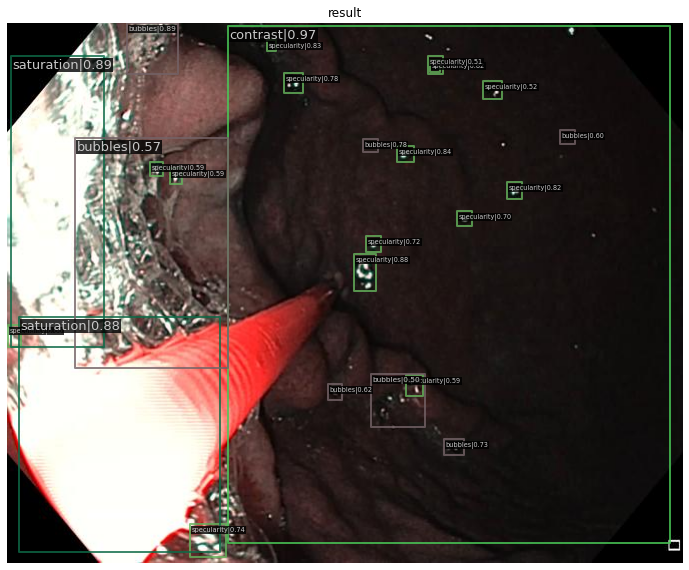

In [ ]:
img = mmcv.imread('/content/dataset/Sequence/Pylseg4_000169.jpg')
#mmdet.apis.show_result_pyplot(model, img, result, score_thr=0.3, title='result', wait_time=0, palette=None, out_file=None)
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result,score_thr=0.5)

In [ ]:
#!cp /content/tutorial_exps/latest.pth /content/drive/Shareddrives/NeuralSystems-Challenge

In [ ]:
import glob


In [ ]:
images_pat = "/content/dataset/Sequence/*.txt"

results = [0]*len(glob.glob(images_pat))
i = 0
for image in glob.glob(images_pat):
  img = mmcv.imread(image)
  model.cfg = cfg
  result = inference_detector(model, img)
  results[i] = result
  i+=1